# Deep Mailing - XGBoost Model - Todas as Dimensões e Dados

O objetivo desse notebook é demonstrar a utilizacao do XGBoost para a criacao de arvores de decisão para a predição de CUPS em mailings.

Em primeiro lugar, definimos os imports que iremos usar...

In [1]:
import xgboost
import numpy as np
import os
import sys
import logging
import gc
import pickle as pickle
import pandas as pd
import dateutil.parser as parser
import os.path
import math
from sklearn.metrics import accuracy_score
from datetime import datetime
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

/home/ubuntu/git/DeepMailing/env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Abaico definimos os diretorios e nomes dos arquivos intermediarios.

In [2]:
log_location = "../logs/"
arquivo_df_pickled_norm = "../intermediate/df.norm.pickle"
arquivo_df_pickled_norm_train = "../intermediate/df.norm.train.pickle"
arquivo_df_pickled_norm_test = "../intermediate/df.norm.test.pickle"
arquivo_df_pickled_norm_train_x = "../intermediate/df.norm.train.x.pickle.npy"
arquivo_df_pickled_norm_train_y = "../intermediate/df.norm.train.y.pickle.npy"
arquivo_df_pickled_norm_test_x = "../intermediate/df.norm.test.x.pickle.npy"
arquivo_df_pickled_norm_test_y = "../intermediate/df.norm.test.y.pickle.npy"

Redefinimos o logger que iremos usar

In [3]:
logger = logging.getLogger()
logging.basicConfig(format="%(asctime)-15s %(message)s",
                    level=logging.DEBUG,
                    filename=os.path.join(log_location,'xgboost.log.' + datetime.now().strftime("%Y%m%d%H%M%S.%f") + '.log'))

Criamos uma função para imprimir tanto no log quanto no notebook...

In [4]:
def print_log(msg):
    logging.debug(msg)
    print(msg)    

Carregamos para a memoria o arquivo normalizado e pickled que foi gerado no notebook de "Preparação de Dados".

In [22]:
print_log("Carregando Pickling normalizado:{}".format(arquivo_df_pickled_norm))    
chamadas = pd.read_pickle(arquivo_df_pickled_norm)

Carregando Pickling normalizado:../intermediate/df.norm.pickle


Verificamos as dimensões do dataframe carregado.... E imprimimos uma amostra do dado que precisamos com apenas as colunas relevantes... Como podemos perceber o nosso modelo considera apenas colunas com valores booleanos (0 ou 1)

In [23]:
print_log(chamadas.shape)
chamadas.loc[:, 'NORM_CARTEIRA_A01':'NORM_DDD_87'].head(10)

(1435423, 103)


,NORM_CARTEIRA_A01,NORM_CARTEIRA_W01,NORM_CARTEIRA_W02,NORM_CARTEIRA_A02,NORM_CARTEIRA_A03,NORM_SEGMENTO_CR,NORM_SEGMENTO_FA,NORM_SEGMENTO_CC,NORM_SEGMENTO_LC,NORM_SEGMENTO_HC,...,NORM_DDD_35,NORM_DDD_93,NORM_DDD_81,NORM_DDD_62,NORM_DDD_17,NORM_DDD_54,NORM_DDD_47,NORM_DDD_31,NORM_DDD_45,NORM_DDD_87
0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Perfeito, então vamos embaralhar os dados e gerar os nossos dados de treinamento e teste. Vamos considerar 70% para treinamento e 30 % para teste. No final, apagamos o dataframe lido para economizar memoria

In [7]:
print_log("Criando Pickling de train e teste...")
chamadas = chamadas.sample(int(len(chamadas.index)))
chamadas_train = chamadas.tail(int(len(chamadas.index) * 0.7))
chamadas_test = chamadas.head(int(len(chamadas.index) * 0.3))
del chamadas

Criando Pickling de train e teste...


Criamos uma função para gerar um arquivo de referencia de colunas a serem usadas q que vai ser importante na hora de gerar a arvore de decisao...

In [8]:
def create_column_reference(header_chamadas_x,arquivo_df_pickled_norm_train_x):
    print_log("Criando Arquivo de referencia de colunas...")
    with open(arquivo_df_pickled_norm_train_x+".txt","w") as f:
        counter = 0
        lista_header = list(header_chamadas_x.columns.values)
        for header in lista_header:
            f.write("{}-{}\n".format(counter,header))
            counter=counter+1

Criamos agora os nossos dataframes de X que são as features e as Y que são os alvos de predição. Também removemos qualquer linha em tentativas seja igual a zero, além de criar um arquivo de referencia com as colunas X que serão usadas no modelo. Esses dataframes serão convertidos para matrizes no formato numpy

In [9]:
print_log("Separando colunas em X e Y...")        
chamadas_train = chamadas_train[(chamadas_train.NORM_TENTATIVAS > 0)]
create_column_reference(chamadas_train.loc[:, chamadas_train.columns.values[2]:'NORM_DDD_87'].head(1), arquivo_df_pickled_norm_train_x)
chamadas_train_x = chamadas_train.loc[:, chamadas_train.columns.values[2]:'NORM_DDD_87'].as_matrix()
chamadas_train_y = chamadas_train.NORM_CUP.as_matrix()
chamadas_test = chamadas_test[(chamadas_test.NORM_TENTATIVAS > 0)]
chamadas_test_x = chamadas_test.loc[:, chamadas_test.columns.values[2]:'NORM_DDD_87'].as_matrix()
chamadas_test_y = chamadas_test.NORM_CUP.as_matrix()


Separando colunas em X e Y...
Criando Arquivo de referencia de colunas...


Após a criação das matrizes numpy, gravamos elas em arquivos.

In [10]:
print_log("Criando arquivos finais em formato NUMPY para consumo pelo algoritmo...")        
np.save(arquivo_df_pickled_norm_train_x,chamadas_train_x)
np.save(arquivo_df_pickled_norm_train_y,chamadas_train_y)
np.save(arquivo_df_pickled_norm_test_x,chamadas_test_x)
np.save(arquivo_df_pickled_norm_test_y,chamadas_test_y)


Criando arquivos finais em formato NUMPY para consumo pelo algoritmo...


Apagamos todos os dados intermediários e rodamos o garbage collector para economizar memória.

In [11]:
print_log("Removendo objetos desnecessarios")        
del chamadas_train_x
del chamadas_train_y
del chamadas_train
del chamadas_test
del chamadas_test_x
del chamadas_test_y
gc.collect()

Removendo objetos desnecessarios


105

Carregamos os objetos numpy em memoria

In [12]:
print_log("Carregando objetos numpy")        
train_x = np.load(arquivo_df_pickled_norm_train_x)
train_y = np.load(arquivo_df_pickled_norm_train_y)
test_x = np.load(arquivo_df_pickled_norm_test_x)
test_y = np.load(arquivo_df_pickled_norm_test_y)

Carregando objetos numpy


Contamos quantos CUPS existem em treinamento e teste...

In [13]:
msg1 = "Train - CUPS Detectados {} num universo de {}".format(len([y for y in train_y if y >0]),len(train_y))
msg2 = "Test - CUPS Detectados {} num universo de {}".format(len([y for y in test_y if y >0]),len(test_y))
print_log(msg1)
print_log(msg2)

Train - CUPS Detectados 1981 num universo de 1004796
Test - CUPS Detectados 850 num universo de 430625


Configuramos os parametros para o XGBoost, especificando que queremos que ele seja o mais exato possivel, que a medida de erro é erro simples e que queremos apenas uma classificacao binaria com um maximo de 1000 interações

In [14]:
param = {}
param['eta'] = 0.2
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'error'
param['tree_method'] = 'exact'
param['silent'] = 0
num_round = 1000

Após a definicão dos paramêtros de teste, criamos as matrizes no formato do XGBoost e treinamos o modelo.

In [15]:
gc.collect()
print_log("Starting model for params:{}".format(param))
dtrain = xgb.DMatrix(train_x, train_y)
dtest = xgb.DMatrix(test_x, test_y)
gpu_res = {}
booster = xgb.train(param, dtrain, num_round, evals=[], evals_result=gpu_res)

Starting model for params:{'eta': 0.2, 'eval_metric': 'error', 'tree_method': 'exact', 'silent': 0, 'objective': 'binary:logistic'}


Após o modelo ser treinado, podemos plotar ele... Para verificar que coluna é cada feature no modelo, por favor ver a lista em anexo no final desse notebook.

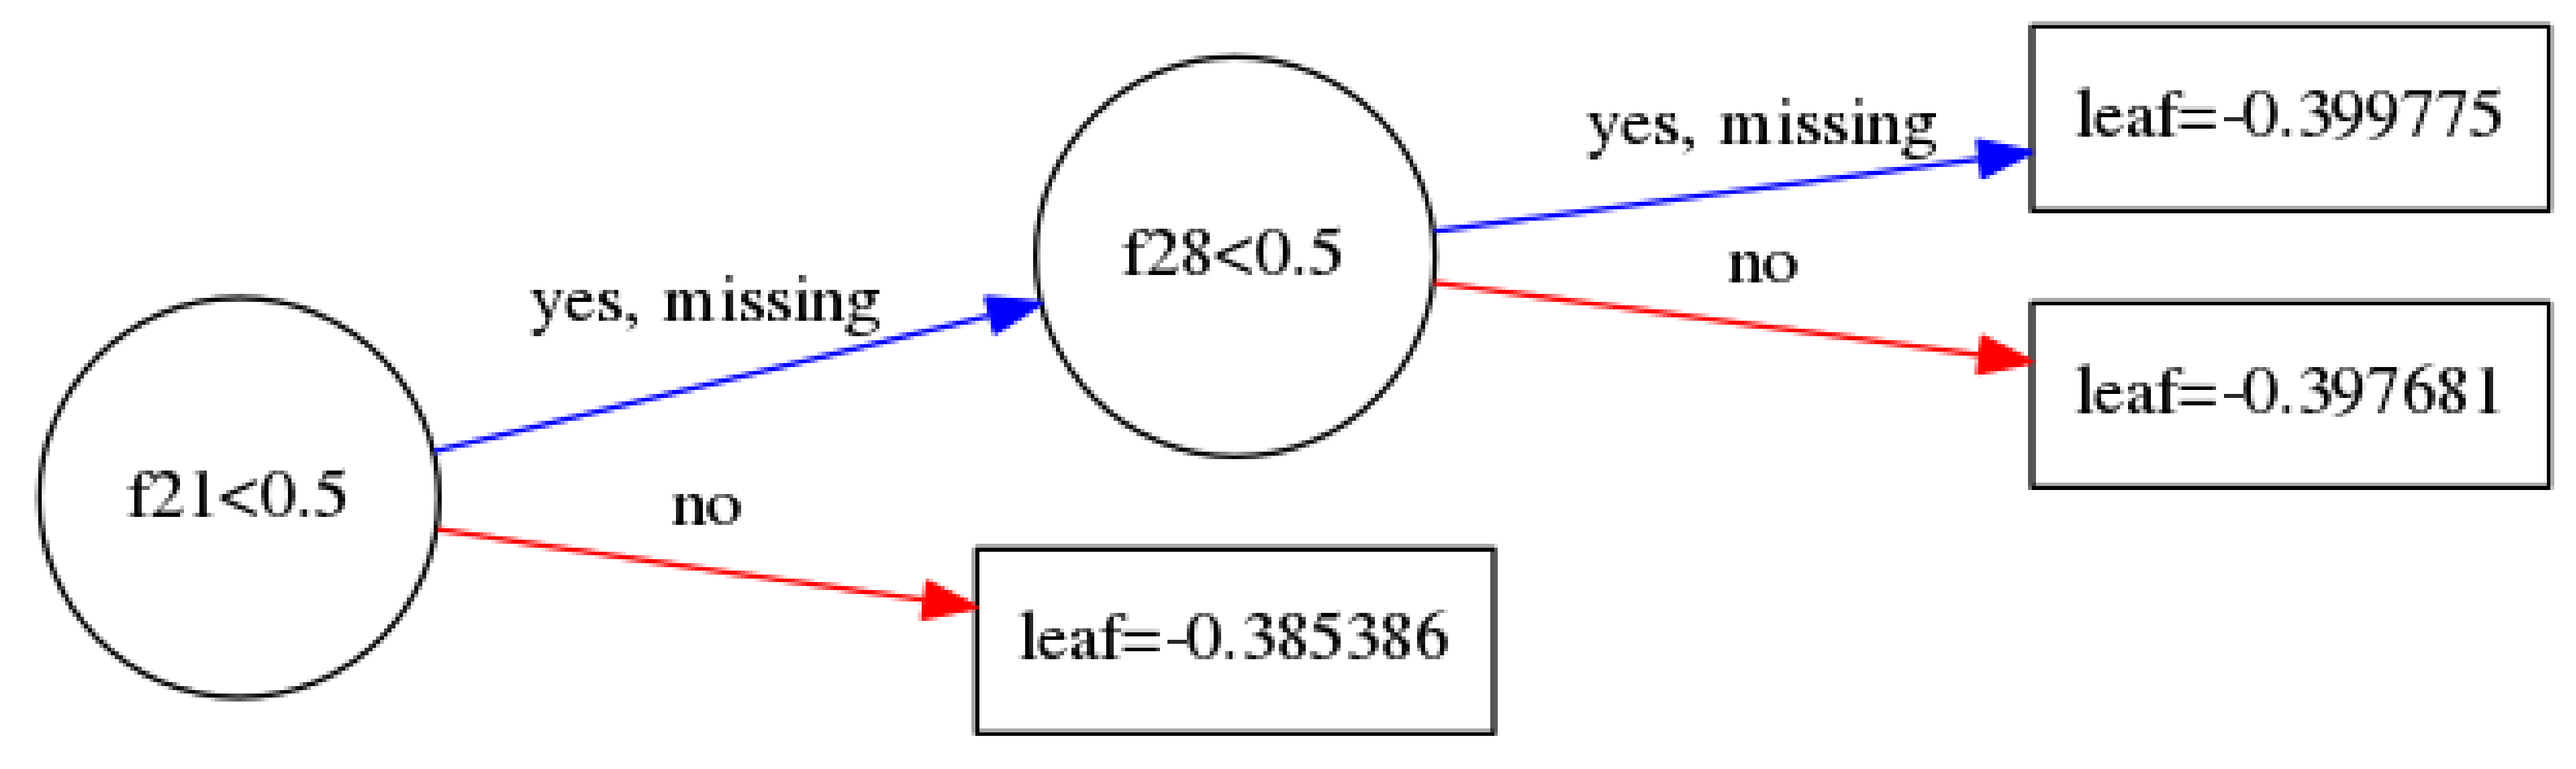

In [16]:
%matplotlib inline
rcParams['figure.figsize'] = 80,50
plot_tree(booster, rankdir='LR')
plt.show()

Agora, vamos tentar predizer os dados com o nosso modelo treinado...

In [17]:
test_y_pred = booster.predict(dtest)
test_predictions = np.array([value for value in test_y_pred])

E Finalmente medir a precisão da nossa predição... Tanto no total quanto em CUPs detectados.

In [18]:
accuracy = accuracy_score(test_y, test_predictions.round())
print_log("CUPS Previstos:{}".format(len([x for x in test_predictions if x > 0.5])))
print_log("CUPS na Base Teste:{}".format(len([x for x in test_y if x > 0.5])))
print_log("Accuracy Total:{}".format(accuracy))
print_log("Accuracy em CUPs:{}".format(len([x for x in test_predictions if x > 0.5]) / len([x for x in test_y if x > 0.5])))

CUPS Previstos:0
CUPS na Base Teste:850
Accuracy Total:0.9980261248185777
Accuracy em CUPs:0.0


Após, vamos salvar o modelo gerado em um arquivo para reuso...

In [20]:
save_file = "../output/{}.model".format(datetime.now().strftime("%Y%m%d.%H%M%S"))
with open(save_file, 'wb') as fp:
    pickle.dump(booster, fp)    
print_log("Model saved as {}".format(save_file))

Model saved as ../output/20171215.162429.model


In [29]:
%%bash 

cat ../intermediate/df.norm.train.x.pickle.npy.txt  

0-NORM_CARTEIRA_A01
1-NORM_CARTEIRA_W01
2-NORM_CARTEIRA_W02
3-NORM_CARTEIRA_A02
4-NORM_CARTEIRA_A03
5-NORM_SEGMENTO_CR
6-NORM_SEGMENTO_FA
7-NORM_SEGMENTO_CC
8-NORM_SEGMENTO_LC
9-NORM_SEGMENTO_HC
10-NORM_SEGMENTO_FT
11-NORM_SEGMENTO_FC
12-NORM_SEGMENTO_MA
13-NORM_PROPENSAO_ALTA
14-NORM_ORIGEM_BUREAU
15-NORM_ORIGEM_BASE INTERNA
16-NORM_STATUS_BUREAU_Indefinido
17-NORM_STATUS_BUREAU_Bom -
18-NORM_STATUS_BUREAU_Bom
19-NORM_STATUS_BUREAU_nan
20-NORM_STATUS_INTERNA_Bom
21-NORM_STATUS_INTERNA_Hot
22-NORM_STATUS_INTERNA_Novo
23-NORM_STATUS_INTERNA_Indefinido
24-NORM_STATUS_INTERNA_Validado
25-NORM_STATUS_TELEFONE_Indefinido
26-NORM_STATUS_TELEFONE_Hot
27-NORM_STATUS_TELEFONE_Validado
28-NORM_STATUS_TELEFONE_Bom
29-NORM_STATUS_TELEFONE_Bom -
30-NORM_STATUS_TELEFONE_Novo
31-NORM_DDD_63
32-NORM_DDD_24
33-NORM_DDD_96
34-NORM_DDD_22
35-NORM_DDD_38
36-NORM_DDD_79
37-NORM_DDD_69
38-NORM_DDD_53
39-NORM_DDD_34
40-NORM_DDD_94
41-NORM_DDD_84
42-NORM_DDD_75
43-NORM_DDD_88
44-NORM_DDD_68
45-NORM_DDD_14
46-